In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model ,neighbors,preprocessing,svm,tree
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler,LabelEncoder
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,accuracy_score,make_scorer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,ExtraTreesClassifier,BaggingClassifier
import sys
from xgboost import XGBRegressor


import vecstack
from vecstack import stacking
from xgboost import XGBClassifier
from scipy.stats import probplot
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score,accuracy_score,make_scorer,log_loss,precision_score
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.svm import NuSVC,SVC
from scipy import std ,mean
from scipy.stats import norm
from scipy import stats
warnings.filterwarnings('ignore')



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


# plt.style.use('dark_background')

sns.set_palette('dark')


plt.rcParams['figure.figsize'] = [14, 7]
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":22,"axes.labelsize":20,"figure.suptitlesize":25}) 


data=pd.read_csv('../input/heart-disease-uci/heart.csv')

scale=['age','chol','trestbps','thalach','oldpeak']
f=data[scale]
scaler=StandardScaler().fit(f.values)
f=scaler.transform(f.values)
data[scale]=f




# DATA DESCRIPTION


age: The person's age in years

sex: (1 = male, 0 = female)

cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)

chol: The person's cholesterol measurement in mg/dl

fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing 

probable or definite left ventricular hypertrophy by Estes' criteria)

thalach: The person's maximum heart rate achieved

exang: Exercise induced angina (1 = yes; 0 = no)

oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot.)

slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

ca: The number of major vessels (0-3)

thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)

target: Heart disease (0 = no, 1 = yes)

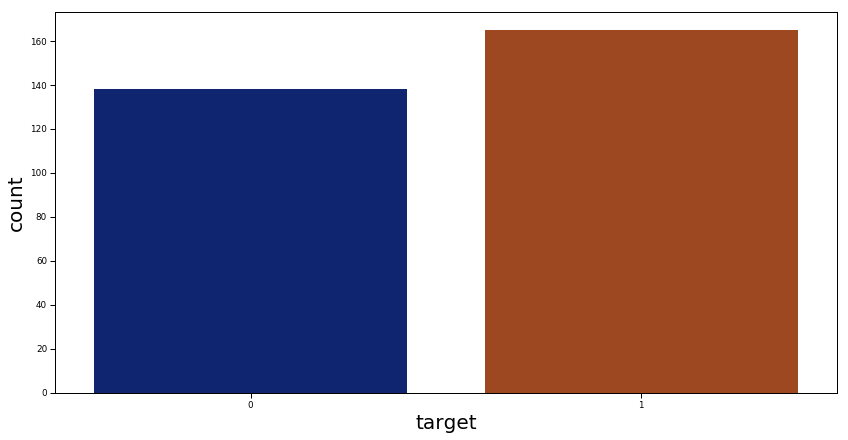

In [2]:
plt.rcParams['figure.figsize'] = [14, 7]
sns.countplot(x="target", data=data);

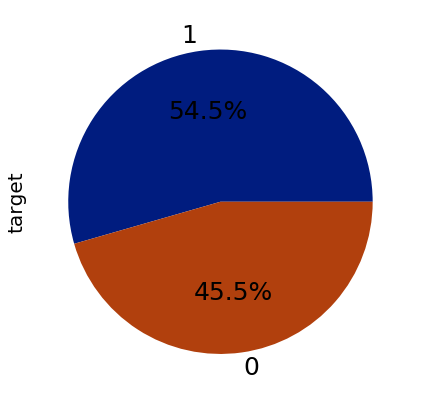

In [3]:
data.target.value_counts().plot.pie(autopct='%1.1f%%',fontsize=25)

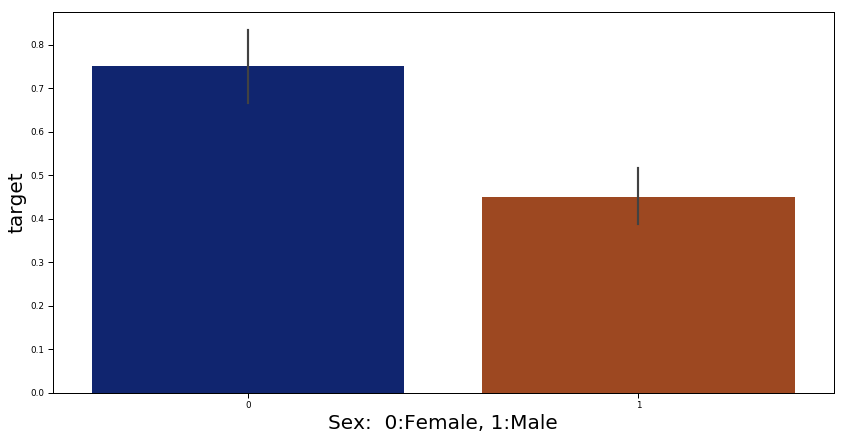

In [4]:
sns.barplot(data.sex,data.target)
plt.xlabel('Sex:  0:Female, 1:Male');

Females have higher ratio,while males have less than 50%


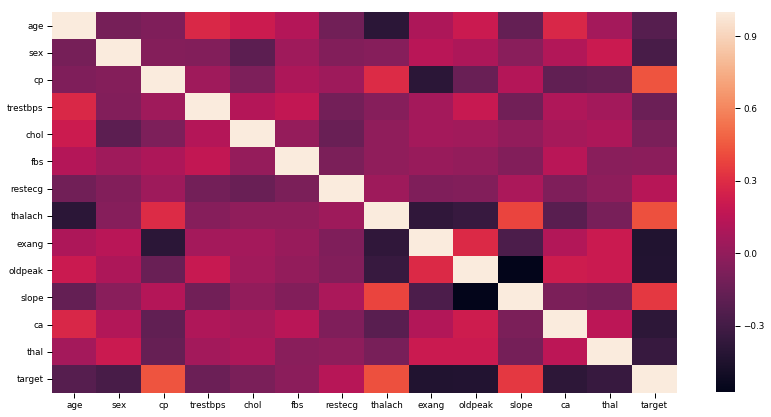

In [5]:
sns.heatmap(data.corr())


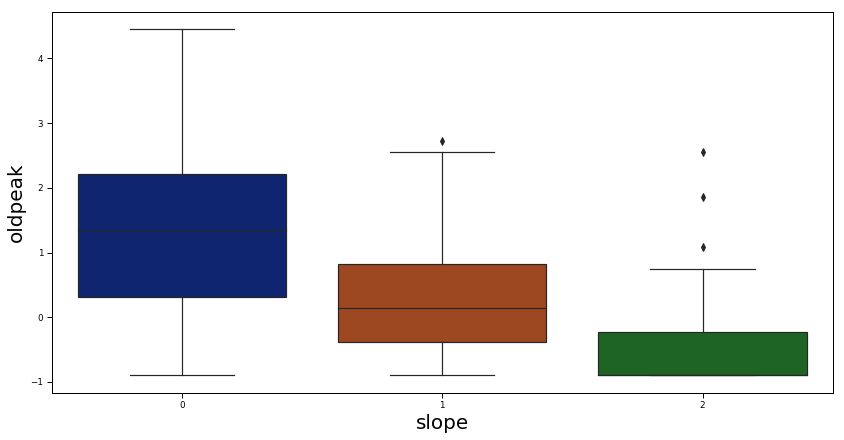

In [6]:
sns.boxplot(data.slope,data.oldpeak)

In [7]:
data.corr().target.sort_values(ascending=False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

In [8]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc

def model(algorithm,dtrain_x,dtrain_y,dtest_x,dtest_y,of_type):
    print('*'*120)
    print ("MODEL")
    algorithm.fit(dtrain_x,dtrain_y)
    predictions = algorithm.predict(dtest_x)
    
    print (algorithm)
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
        
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True, annot_kws={"size": 23,'va':'top'})
    plt.title("CONFUSION MATRIX")
    
    predicting_probabilites = algorithm.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE")
    
    if  of_type == "feat":
        
        dataframe = pd.DataFrame(algorithm.feature_importances_,dtrain_x.columns).reset_index()
        dataframe = dataframe.rename(columns={"index":"features",0:"coefficients"})
        dataframe = dataframe.sort_values(by="coefficients",ascending = False)
        plt.subplot(223)
        ax = sns.barplot(x = "coefficients" ,y ="features",data=dataframe,palette="husl")
        plt.title("FEATURE IMPORTANCES",fontsize =17)
        for i,j in enumerate(dataframe["coefficients"]):
            ax.text(.011,i,j,weight = "bold")
    
    elif of_type == "coef" :
        
        dataframe = pd.DataFrame(algorithm.coef_.ravel(),dtrain_x.columns).reset_index()
        dataframe = dataframe.rename(columns={"index":"features",0:"coefficients"})
        dataframe = dataframe.sort_values(by="coefficients",ascending = False)
        plt.subplot(223)
        ax = sns.barplot(x = "coefficients" ,y ="features",data=dataframe,palette="husl")
        plt.title("FEATURE IMPORTANCES",fontsize =20)
        for i,j in enumerate(dataframe["coefficients"]):
            ax.text(.011,i,j,weight = "bold")
            
    elif of_type == "none" :
        return (algorithm)


 # MODELS (before data tranformation)

************************************************************************************************************************
MODEL
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score : 0.8524590163934426

classification report :
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.84      0.91      0.87        34

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.85      0.85      0.85        61



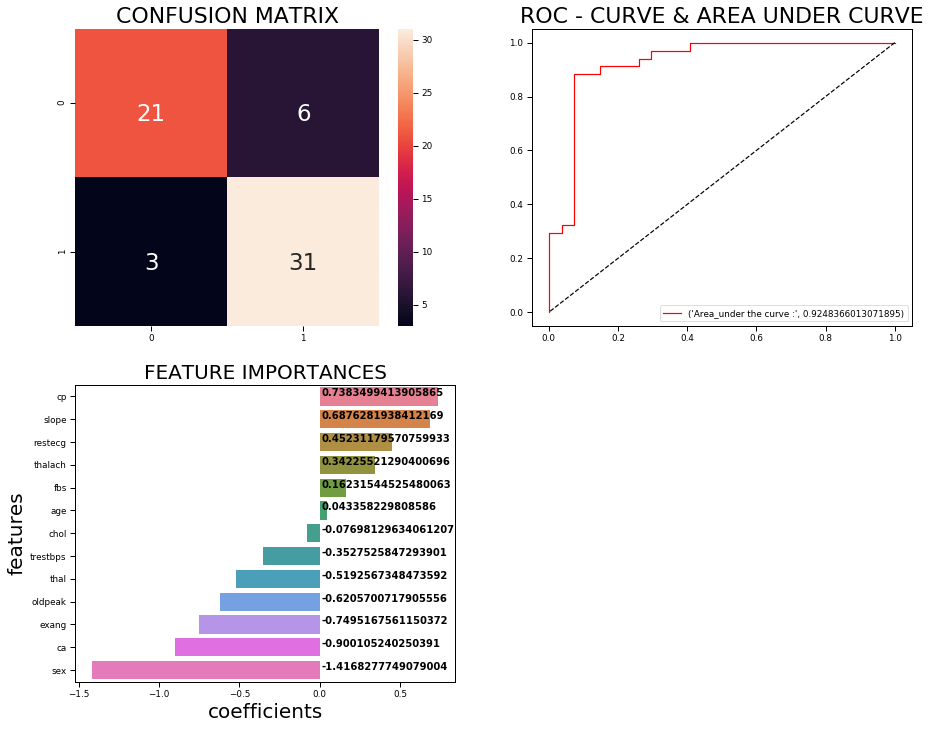

In [9]:
x=data.drop('target',1)
y=data['target']
x,y=shuffle(x,y)
xtr,xtest,ytr,ytest=train_test_split(x,y, test_size=0.2)

model(LogisticRegression(),xtr,ytr,xtest,ytest,'coef')


************************************************************************************************************************
MODEL
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

accuracy_score : 0.9016393442622951

classification report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        27
           1       0.89      0.94      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



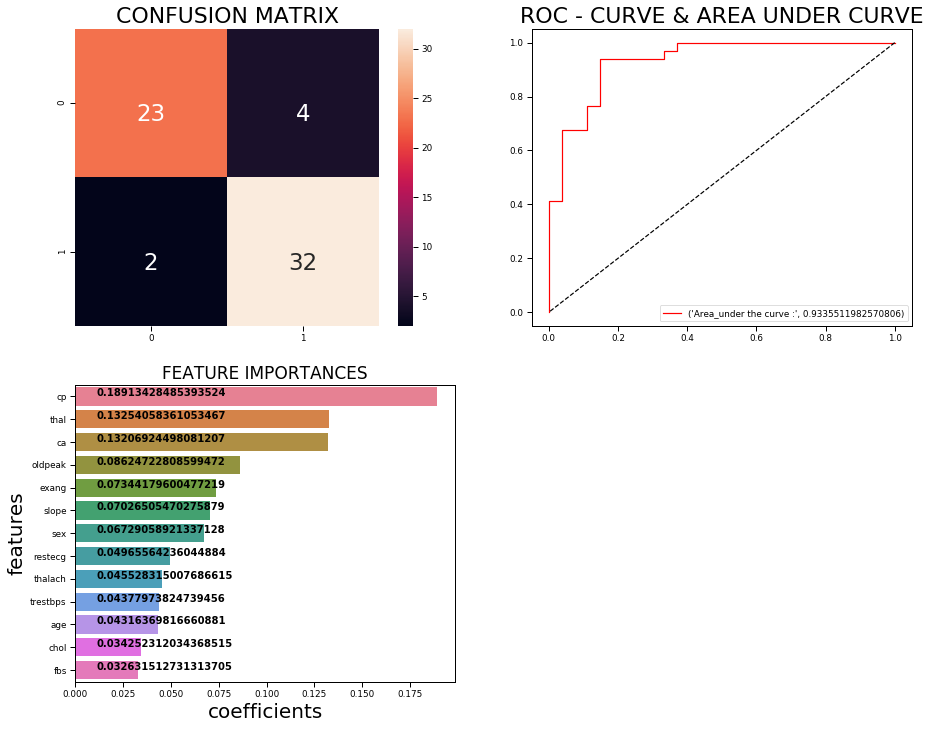

In [10]:

model(XGBClassifier(),xtr,ytr,xtest,ytest,'feat')


In [11]:
from sklearn.tree import DecisionTreeClassifier
dec_tree=DecisionTreeClassifier()
cross_val_score(dec_tree,x,y, cv=4)

array([0.79220779, 0.72368421, 0.73333333, 0.61333333])

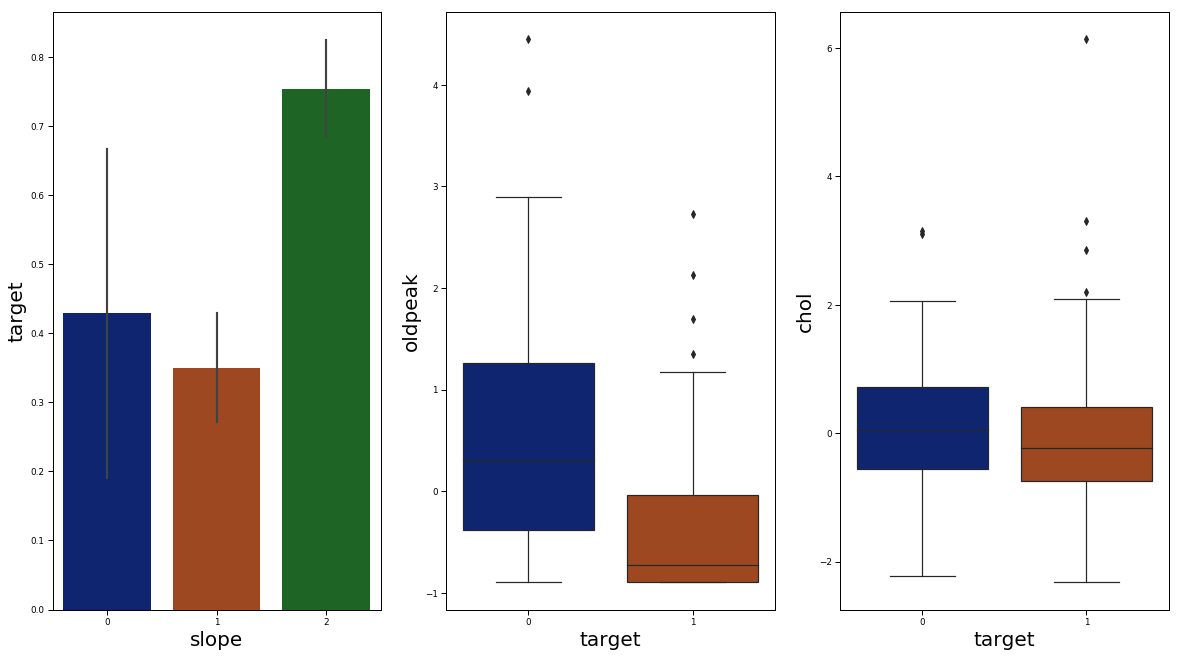

In [12]:
fig,axes=plt.subplots(1,3,figsize=(20,11))

sns.barplot(data.slope,data.target,ax=axes[0])
sns.boxplot(data.target,data.oldpeak,ax=axes[1])
sns.boxplot(data.target,data.chol,ax=axes[2])

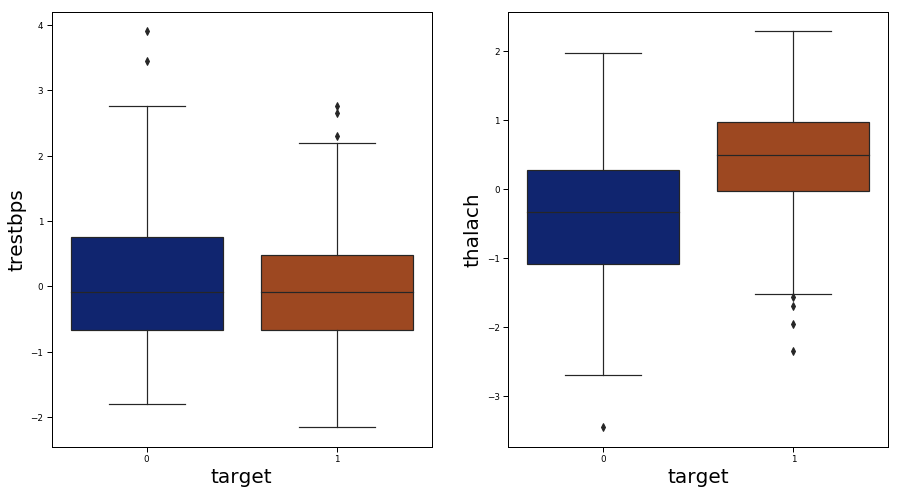

In [13]:
fig,axes=plt.subplots(1,2,figsize=(15,8))
sns.boxplot(data.target,data.trestbps,ax=axes[0])
sns.boxplot(data.target,data.thalach,ax=axes[1])

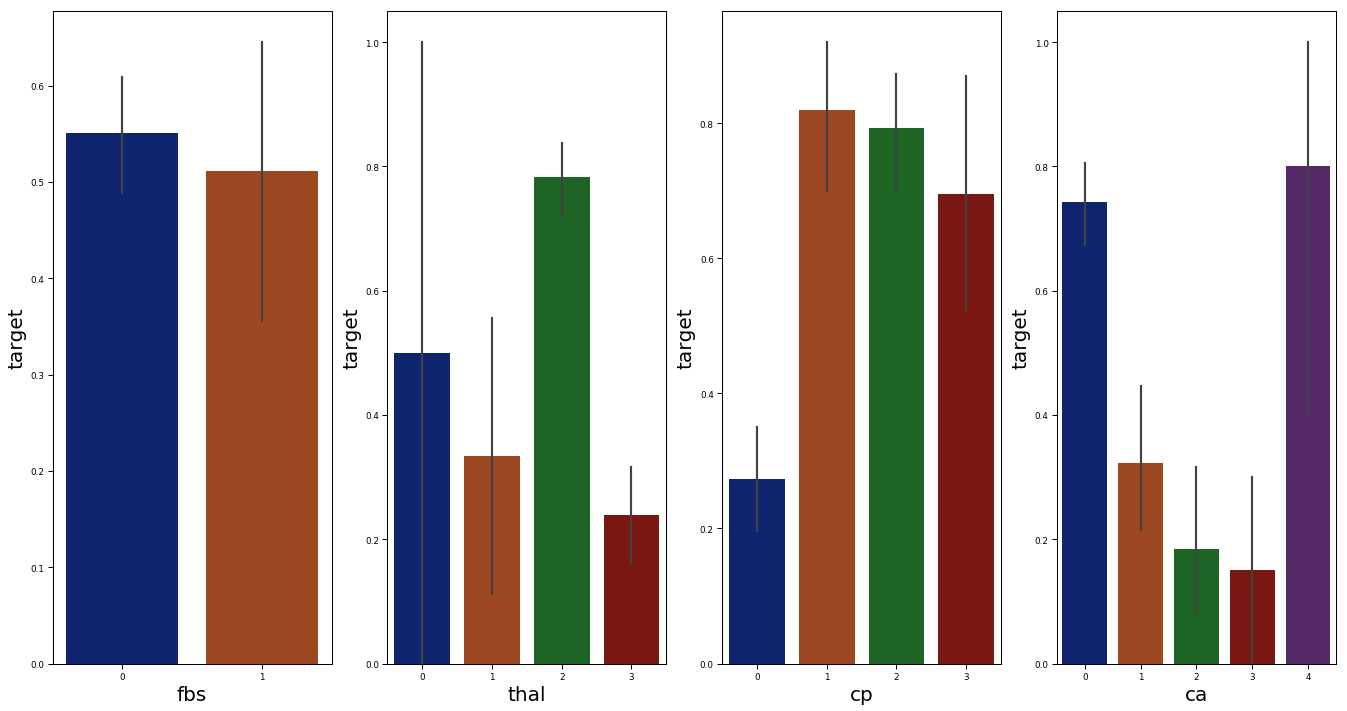

In [14]:
fig,axes=plt.subplots(1,4,figsize=(23,12))

sns.barplot(data.fbs,data.target,ax=axes[0])
sns.barplot(data.thal,data.target,ax=axes[1])
sns.barplot(data.cp,data.target,ax=axes[2])
sns.barplot(data.ca,data.target,ax=axes[3])

we see why these features are important!

# PREPARING DATA

In [15]:
data.drop(data[(data.target==1) & (data.oldpeak>1)].index,axis=0,inplace=True)
data.drop(data[(data.target==1) & (data.chol>2)].index,axis=0,inplace=True)
data.drop(data[(data.target==1) & (data.thalach<-1.5)].index,axis=0,inplace=True)

In [16]:
data=pd.get_dummies(data, columns=['cp','restecg','slope','thal'],drop_first=True)

# TESTING AT NEW DATA

************************************************************************************************************************
MODEL
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score : 0.9482758620689655

classification report :
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.90      1.00      0.95        26

    accuracy                           0.95        58
   macro avg       0.95      0.95      0.95        58
weighted avg       0.95      0.95      0.95        58



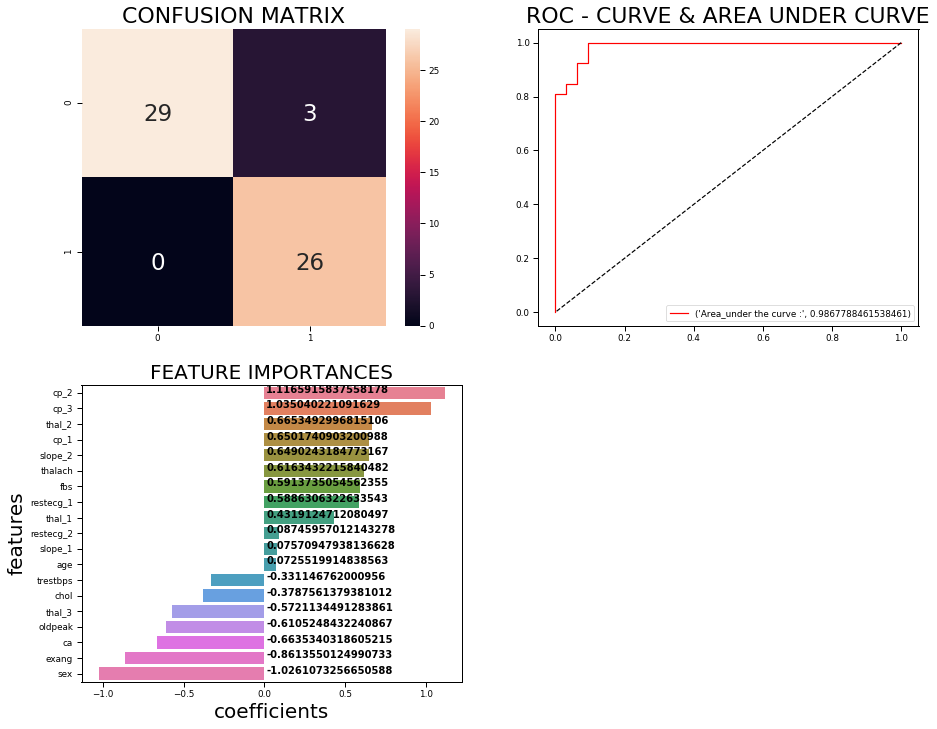

In [17]:
x=data.drop('target',1)
y=data.target
x,y=shuffle(x,y)
xtr,xtest,ytr,ytest=train_test_split(x,y, test_size=0.2)
model(LogisticRegression(),xtr,ytr,xtest,ytest,'coef')

In [18]:

rf=RandomForestClassifier()
reg=LogisticRegression()
k=KNeighborsClassifier()
xg=XGBClassifier(max_depth=3,learning_rate=0.1)
svc=SVC()
model=[rf,reg,k,xg,dec_tree,svc]
voting=VotingClassifier([('rf',model[0]),('reg',model[1]),('k',model[2]),('xg',model[3]),('dec_tree',model[4]),('svc',model[5])],weights=[1,2,1,1,1,1])



In [19]:


Str,Ste=stacking(model,xtr,ytr,xtest,regression=False,metric=accuracy_score,shuffle=True,verbose=0,stratified=True)
print(
    
     'LogisticRegression:',cross_val_score(LogisticRegression(),x,y,cv=5).mean(),
     
     '\n DecisionTreeClassifier:' ,cross_val_score(DecisionTreeClassifier(),x,y, cv=5).mean(),
      
      
      '\n XGB:',cross_val_score(xg,x,y, cv=5).mean(),
      
      
      '\n KNeighbors:',cross_val_score(KNeighborsClassifier(n_neighbors=6),x,y, cv=5).mean(),
      
      
      
      '\n RandomForest:',cross_val_score(RandomForestClassifier(),x,y, cv=5).mean(),
      
      
      
      '\n SVC:',cross_val_score(SVC(),x,y, cv=5).mean(),
      
      
      '\n Voting:',cross_val_score(voting,x,y, cv=5).mean(),
      
      
      
      '\n Stacked w SVC ',cross_val_score(SVC(),Str,ytr,cv=4).mean(),
      
      
      
       '\n Stacked w Logistic:', cross_val_score(LogisticRegression(),Str,ytr,cv=4).mean(),
      
      
      
      '\n Stacked w voting ',cross_val_score(voting,Str,ytr,cv=4).mean()
      
    
    )
      
      
    


LogisticRegression: 0.8359605911330048 
 DecisionTreeClassifier: 0.7514778325123153 
 XGB: 0.8044334975369459 
 KNeighbors: 0.82192118226601 
 RandomForest: 0.7833743842364531 
 SVC: 0.8220443349753694 
 Voting: 0.835960591133005 
 Stacked w SVC  0.7943349753694582 
 Stacked w Logistic: 0.7810960591133005 
 Stacked w voting  0.7635467980295566


# FINDING BEST VALUE OF K IN KNN


Best acc :82.90640394088669 5


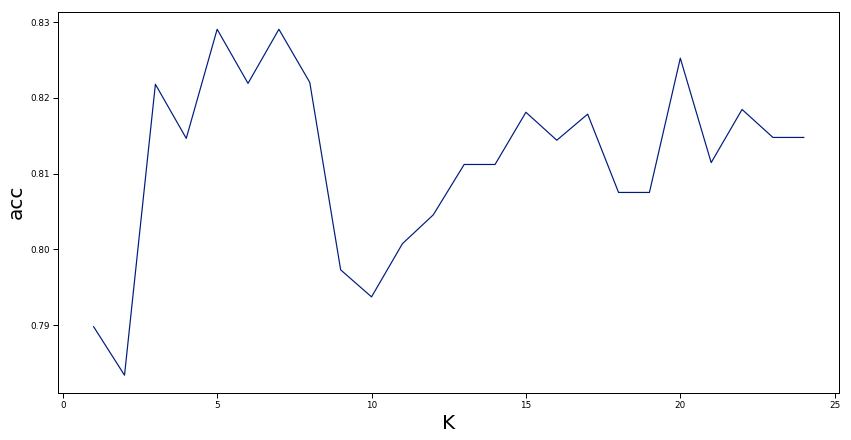

In [20]:
li=[]
for i in range(1,25):
    k = KNeighborsClassifier(n_neighbors = i) 
    li.append(cross_val_score(k,x,y,cv=5).mean())
    
plt.plot(range(1,25),li)

plt.xlabel("K")

plt.ylabel("acc")

acc=max(li)*100
best_k=li.index(max(li))+1
print(f"Best acc :{acc}",best_k)